#Connecting to bigquery table and loading cleaned trip data

In [1]:
from google.colab import auth
auth.authenticate_user()
print('User Authenticated')
project_id = 'causefinder'
%load_ext google.colab.data_table

User Authenticated


In [0]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

rawData = client.query('''
SELECT DISTINCT 
RouteNumber,
RouteSequence,
CASE 
WHEN VehicleDirection='Outbound' THEN 1
ELSE 2 END AS VehicleDirection,
BusStopId,
BusStopAddress,
BlockRef,
JourneyRef,
EXTRACT(DAYOFWEEK FROM AimedArrivalTime) as DayOfWeek, 
EXTRACT(HOUR FROM AimedArrivalTime) as HourOfDay,
TIMESTAMP_DIFF(AimedArrivalTime,ExpectedArrivalTime,MINUTE) as ArrivalDelayPrediction
FROM `causefinder.TripDB.TripDataCleaned`
ORDER BY RouteNumber,RouteSequence,VehicleDirection,BusStopId,BusStopAddress,
BlockRef,JourneyRef,DayOfWeek,HourOfDay,ArrivalDelayPrediction
''').to_dataframe()


In [3]:
import numpy as np
import seaborn as sns
import pandas as pd

sns.set(style='white')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
df=rawData.copy(deep=True)
df.head(10)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,RouteNumber,RouteSequence,VehicleDirection,BusStopId,BusStopAddress,BlockRef,JourneyRef,DayOfWeek,HourOfDay,ArrivalDelayPrediction
0,1,0,1,226,Shanard Road,1001,4326,2,6,24
1,1,0,1,226,Shanard Road,1001,4326,3,6,24
2,1,0,1,226,Shanard Road,1001,4326,4,6,24
3,1,0,1,226,Shanard Road,1001,4326,5,6,24
4,1,0,1,226,Shanard Road,1001,4326,6,6,24
5,1,0,1,226,Shanard Road,1001,4328,2,9,25
6,1,0,1,226,Shanard Road,1001,4328,3,9,24
7,1,0,1,226,Shanard Road,1001,4328,4,9,24
8,1,0,1,226,Shanard Road,1001,4328,5,9,25
9,1,0,1,226,Shanard Road,1001,4328,6,9,25


#Plotting Heatmap to find correlation among the Attributes

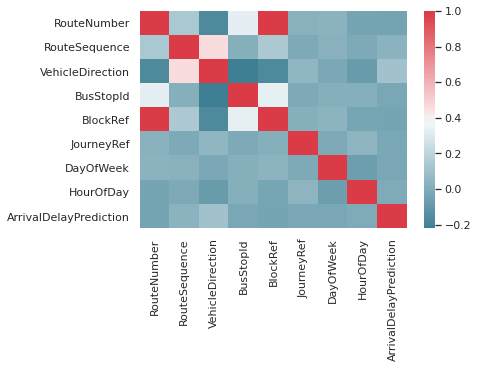

In [4]:
sns.heatmap(df.corr(),cmap=cmap)

# LabelEncoding & Binning Section

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer

def LabelEncoding(col):
  encoder = LabelEncoder()
  encoder.fit(df[col])
  list(encoder.classes_)
  return encoder.transform(df[col])

def KBinsDiscretizing(currCol):
  discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
  discretizer.fit(df[currCol])
  return discretizer.transform(df[currCol])

df['BlockRefEncoded']=LabelEncoding('BlockRef')
#df['VehicleRefEncoded']=LabelEncoding('VehicleRef')
df['JourneyRefEncoded']= LabelEncoding('JourneyRef')
#df['VehicleDirectionNew']= LabelEncoding('VehicleDirection')
#df['DestinationStopIdEncoded']= LabelEncoding('DestinationStopId')
df['BusStopIdEncoded']= LabelEncoding('BusStopId')
df['BusStopAddressEncoded'] = LabelEncoding('BusStopAddress')
df['RouteNumberEncoded'] = LabelEncoding('RouteNumber')

#Dropping the Redundant Columns (BlockRef,JourneyRef and BusStopAddress) and Retaining RouteNumber and BusStopId as they will be required for feature engineering

In [0]:
df = df.drop(['BlockRef','JourneyRef',
              'BusStopAddress'],axis =1, errors='ignore')

#Plotting HeatMap for Correlation

,RouteNumber,RouteSequence,VehicleDirection,BusStopId,DayOfWeek,HourOfDay,ArrivalDelayPrediction,BlockRefEncoded,JourneyRefEncoded,BusStopIdEncoded,BusStopAddressEncoded,RouteNumberEncoded
0,1,0,1,226,2,6,24,0,154,23,21,0
1,1,0,1,226,3,6,24,0,154,23,21,0
2,1,0,1,226,4,6,24,0,154,23,21,0
3,1,0,1,226,5,6,24,0,154,23,21,0
4,1,0,1,226,6,6,24,0,154,23,21,0
5,1,0,1,226,2,9,25,0,156,23,21,0
6,1,0,1,226,3,9,24,0,156,23,21,0
7,1,0,1,226,4,9,24,0,156,23,21,0
8,1,0,1,226,5,9,25,0,156,23,21,0
9,1,0,1,226,6,9,25,0,156,23,21,0


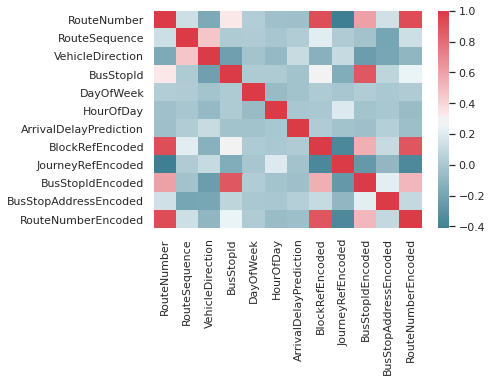

In [0]:
sns.heatmap(df.corr(),cmap=cmap)
df.head(10)

#Spliting Data Into Train and Test

In [0]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df.drop('ArrivalDelayPrediction', axis=1), df['ArrivalDelayPrediction'], test_size=0.2, random_state=42)

#Basic Sanity Testing with Linear Regression:

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

regressor = LinearRegression(fit_intercept=True,normalize=True, copy_X=True)  
regressor.fit(train_x, train_y)
y_pred = regressor.predict(test_x)
regressor.score(test_x,test_y)

0.055738222477582866

#SVR Model execution (Before Feature Engineering):

##GridsearchCV to find  optimum parameters for SVR:

In [0]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 10, 100], 'gamma' : [0.001, 0.01, 0.1, 0.001]}
grid_search = GridSearchCV(SVR(epsilon = 0.01), param_grid, cv = 5)
grid_search.fit(train_x, train_y)
result=pd.DataFrame(grid_search.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]
print(result)

In [0]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.001, epsilon=1)
svr_rbf.fit(train_x, train_y)
y_pred_svr = svr_rbf.predict(test_x)
svr_rbf.score(test_x,test_y)

0.2843515977268084

#XGBoost Model Execution (Before Feature Engineering):

In [0]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_reg.fit(train_x,train_y)
preds_y = xg_reg.predict(test_x)
rmse = np.sqrt(mean_squared_error(test_y, preds_y))
print(xg_reg.score(test_x,test_y))

0.6837655067939301


#RandomForest Model Execution (Before Feature Engineering):

In [0]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators = 100, random_state = 0)
regr.fit(train_x, train_y)
regr.predict(test_x)
regr.score(test_x,test_y)

0.6645777325550246

In [0]:
print(df.dtypes)

RouteNumber               int64
RouteSequence             int64
VehicleDirection          int64
BusStopId                 int64
DayOfWeek                 int64
HourOfDay                 int64
ArrivalDelayPrediction    int64
BlockRefEncoded           int64
JourneyRefEncoded         int64
BusStopIdEncoded          int64
BusStopAddressEncoded     int64
RouteNumberEncoded        int64
dtype: object


#Applying Feature Engineering Different Methods:

# Synthetic Features to Improve Prediction

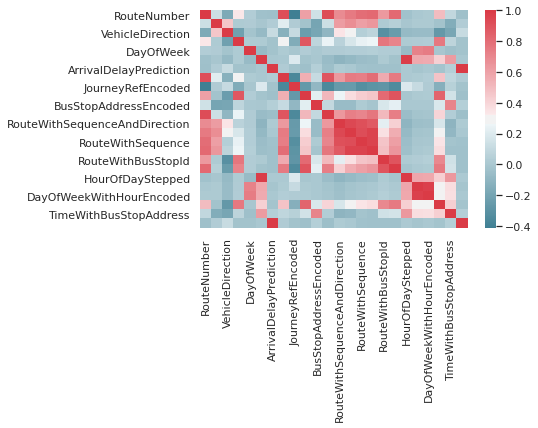

In [0]:
df['RouteWithSequenceAndDirection']=df['RouteNumber']*df['RouteSequence']*df['VehicleDirection']
df['RouteWithSeqAndDirEncoded'] = LabelEncoding('RouteWithSequenceAndDirection')

df['RouteWithSequence']=df['RouteNumber']*df['RouteSequence']
df['RouteWithSeqEncoded'] = LabelEncoding('RouteWithSequence')

df['RouteWithBusStopId']=df['RouteNumber']*df['BusStopId']
df['RouteWithBusStopIdEncoded'] = LabelEncoding('RouteWithBusStopId')

HOUR_STEP_VAL=3
df['HourOfDayStepped']= df['HourOfDay'].apply(lambda x: int(x/HOUR_STEP_VAL)*HOUR_STEP_VAL)

df['DayOfWeekWithHour']=df['HourOfDayStepped']*df['DayOfWeek']
df['DayOfWeekWithHourEncoded']=LabelEncoding('DayOfWeekWithHour')

df['TimeWithBusStop']=df['HourOfDayStepped']*(df['BusStopIdEncoded']+1)

df['TimeWithBusStopAddress']=df['HourOfDayStepped']*(df['BusStopAddressEncoded']+1)

DELAY_STEP_VAL=1
df['ArrivalDelayPredictionStepped']= df['ArrivalDelayPrediction'].apply(lambda x: int(x/DELAY_STEP_VAL)*DELAY_STEP_VAL)

sns.heatmap(df.corr(),cmap=cmap)

# Downcasting to 8 bit integer for performance improvement

In [0]:
def intDownCaster(col):
    return pd.to_numeric(df[col], downcast='integer')

for column in df:
    df[column]=intDownCaster(column)

print(df.dtypes)

RouteNumber                       int8
RouteSequence                     int8
VehicleDirection                  int8
BusStopId                        int16
DayOfWeek                         int8
HourOfDay                         int8
ArrivalDelayPrediction            int8
BlockRefEncoded                   int8
JourneyRefEncoded                int16
BusStopIdEncoded                 int16
BusStopAddressEncoded             int8
RouteNumberEncoded                int8
RouteWithSequenceAndDirection    int16
RouteWithSeqAndDirEncoded        int16
RouteWithSequence                int16
RouteWithSeqEncoded              int16
RouteWithBusStopId               int32
RouteWithBusStopIdEncoded        int16
HourOfDayStepped                  int8
DayOfWeekWithHour                int16
DayOfWeekWithHourEncoded          int8
TimeWithBusStop                  int16
TimeWithBusStopAddress           int16
ArrivalDelayPredictionStepped     int8
dtype: object


# Dropping Redundant Coloumns while keeping encoded Columns Data

,VehicleDirection,BlockRefEncoded,JourneyRefEncoded,BusStopIdEncoded,BusStopAddressEncoded,RouteNumberEncoded,RouteWithSeqAndDirEncoded,RouteWithSeqEncoded,RouteWithBusStopIdEncoded,HourOfDayStepped,DayOfWeekWithHourEncoded,TimeWithBusStop,TimeWithBusStopAddress,ArrivalDelayPredictionStepped
0,1,0,154,23,21,0,0,0,29,6,2,144,132,24
1,1,0,154,23,21,0,0,0,29,6,4,144,132,24
2,1,0,154,23,21,0,0,0,29,6,6,144,132,24
3,1,0,154,23,21,0,0,0,29,6,8,144,132,24
4,1,0,154,23,21,0,0,0,29,6,9,144,132,24
5,1,0,156,23,21,0,0,0,29,9,4,216,198,25
6,1,0,156,23,21,0,0,0,29,9,7,216,198,24
7,1,0,156,23,21,0,0,0,29,9,9,216,198,24
8,1,0,156,23,21,0,0,0,29,9,11,216,198,25
9,1,0,156,23,21,0,0,0,29,9,13,216,198,25


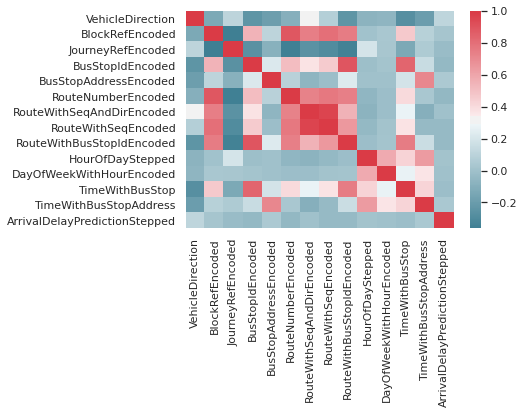

In [0]:
df = df.drop(['BusStopId','RouteWithSequenceAndDirection',
              'RouteWithSequence','RouteNumber','ArrivalDelayPrediction',
              'RouteSequence','HourOfDay','DayOfWeek','DayOfWeekWithHour',
              'RouteWithBusStopId'],axis =1, errors='ignore')
sns.heatmap(df.corr(),cmap=cmap)
df.head(10)

# Train & Test Data Splitting

In [0]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df.drop('ArrivalDelayPredictionStepped', axis=1), df['ArrivalDelayPredictionStepped'], test_size=0.2, random_state=42)

#Basic Sanity Testing with Linear Regression:

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

regressor = LinearRegression(fit_intercept=True,normalize=True, copy_X=True)  
regressor.fit(train_x, train_y)
y_pred = regressor.predict(test_x)
regressor.score(test_x,test_y)

0.07154651202598361

#SVR regressor Model (After Feature Engineering)

In [0]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.001, epsilon=1)
svr_rbf.fit(train_x, train_y)
y_pred_svr = svr_rbf.predict(test_x)
svr_rbf.score(test_x,test_y)

0.5468251486414953

#XGBoost Regressor Model (After Feature Engineering)

In [0]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_reg.fit(train_x,train_y)
preds_y = xg_reg.predict(test_x)
rmse = np.sqrt(mean_squared_error(test_y, preds_y))
print(xg_reg.score(test_x,test_y))

0.692547970879114


#RandomForest Regressor Model (After Feature Engineering)

In [0]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators = 100, random_state = 0)
regr.fit(train_x, train_y)
regr.predict(test_x)
regr.score(test_x,test_y)

0.6649772355300012